# Wine Quality Classification
Mick Carter

---

In this notebook I build a model to predict the quality of wine from an array of features using a decision tree classification model. The [wine quality data set](https://archive.ics.uci.edu/ml/datasets/wine+quality) comes from the UCI Machine Learning Repository, and contains .csv files for both red and white wines, with a combined total of 6,497 wines. Per the [paper in which the data set was originated](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub), each wine was classified by at least three experts on a scale of 0-10, with 0 being poor and 10 being excellent. Cortez et al. created separate SVM classifiers for red and white wines, with reported accuracies of ~90%. This data-driven quality prediction is what I am attempting to reproduce with my classification model, however, unlike Cortez et al., I am combining red and white wine data to create a single color-agnostic classifier. The combined red/white data set is split into train/test sets at a ratio of 9:1 for the sake of testing out different models and creating a parity plot. Class imbalances are rectified by over-sampling of underrepresented classes using [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) to artificially increase the number of low- and high-quality wines in the training set. Following an investigation of a handful of classification models, the training portion of the data is used to fit an [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), with optimal hyperparameters and the corresponding prediction accuracy estimate determined via a [randomized search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) of 100 parameter combinations and 5 fold cross-validation. Finally, a violin parity plot is used to demonstrate the predictive ability of the classification model.

## Imports
This analysis depends on the following packages:
### Julia
* [CSV](https://juliadata.github.io/CSV.jl/stable/)
* [DataFrames](https://juliadata.github.io/DataFrames.jl/stable/man/getting_started/#Installation-1)
* [PyPlot](https://github.com/JuliaPy/PyPlot.jl)
* [PyCall](https://pkg.julialang.org/docs/PyCall/GkzkC/1.91.2/autodocs/)
* [ScikitLearn](https://scikitlearnjl.readthedocs.io/en/latest/)
* [Printf](https://docs.julialang.org/en/v1/stdlib/Printf/)

### Python
* [matplotlib](https://matplotlib.org/3.1.1/users/installing.html)
* [seaborn](https://seaborn.pydata.org/installing.html)
* [scikit-learn](https://scikit-learn.org/stable/install.html)
* [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/install.html)

In [1]:
using CSV, DataFrames, PyPlot, PyCall, ScikitLearn, Printf
import ScikitLearn.CrossValidation: train_test_split

sns = pyimport("seaborn")
sns.set_context("notebook")
sns.set_palette("muted")

ENV["COLUMNS"] = 300;

## Load data
Red and white dataframes are loaded in, checked for the correct number of entries, and combined into a single dataframe

In [2]:
df_red = CSV.read("winequality-red.csv")
n_red = nrow(df_red)
@assert n_red == 1599

df_white = CSV.read("winequality-white.csv")
n_white = nrow(df_white)
@assert n_white == 4898
@assert names(df_red) == names(df_white)

df = [df_red; df_white]
n_wines = n_red + n_white
(df_red, df_white) = (nothing, nothing)
first(df, 5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6
5,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Visualise data distributions

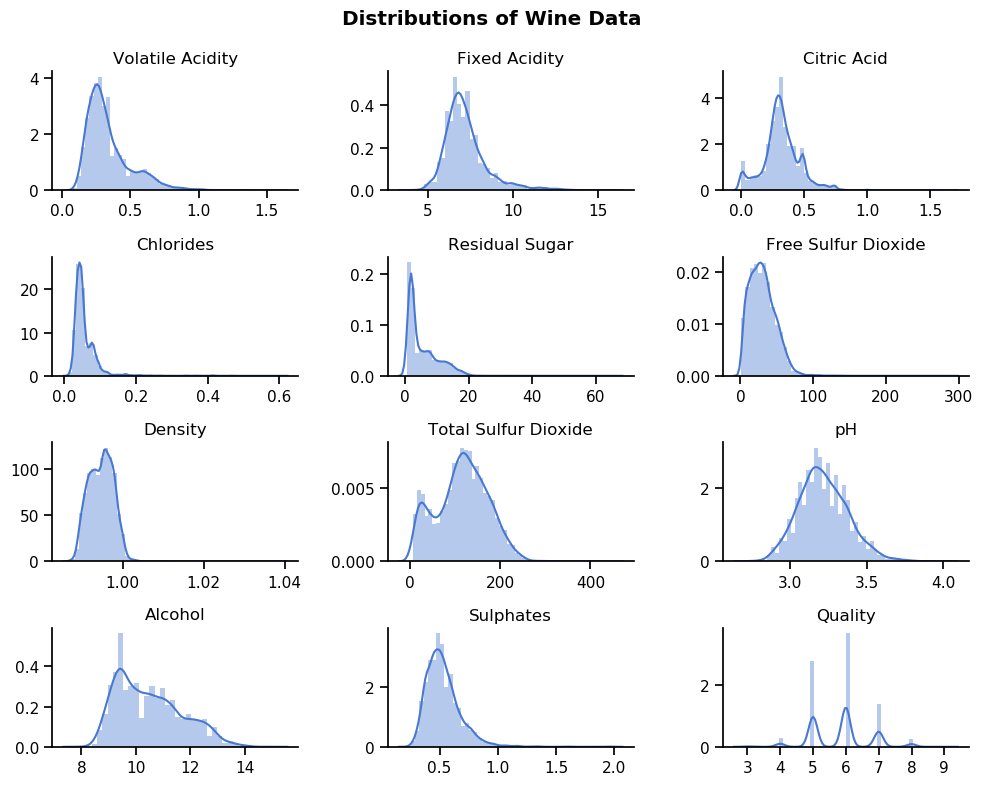

In [3]:
n_col = ncol(df)
plot_cols = 3
fig, ax = subplots(n_col÷plot_cols, plot_cols, figsize=(10, 2*n_col÷plot_cols))
row, col = 0, 0
for (i, key) in enumerate(names(df))
    row = Integer(ceil(i / plot_cols))
    col = plot_cols - i % plot_cols
    sns.distplot(df[!, key], ax=ax[row, col])
    if key == :pH
        key_str = "pH"
    else
        key_str = titlecase(String(key))
    end
    ax[row, col].set_title(key_str)
end
ax[row, col].set_xticks(range(3, stop=9))
fig.suptitle("Distributions of Wine Data", weight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.95])
sns.despine()

## Prepare features and targets for scikit-learn

In [4]:
features = [n for n in names(df) if n != :quality]
n_features = length(features)
X = ones(n_wines, n_features) * NaN
y = df[!, :quality]
for (i, f) in enumerate(features)
    X[:, i] = df[!, f]
end

## Split data
We were asked to both provide a parity plot and use K-folds cross-validation. A parity plot requires withholding some data. Since cross-validation is used in this analysis, 90% of the data is be used to tune hyperparameters and train the model, while the final 10% is withheld to build the parity plot.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.9,
    shuffle=true
)
println("Data Separated!")
println("test points\t\t", size(X_test)[1])
println("train points\t\t", size(X_train)[1])

Data Separated!
test points		650
train points		5847


## Resample training data
Because of the imbalance in qualities, [imblearn's SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) implementation is used to synthetically boost the amount of minority data (i.e. low- and high-quality wines).

In [6]:
ovs = pyimport("imblearn.over_sampling")
X_train, y_train = ovs.SMOTE(k_neighbors=4).fit_resample(X_train, y_train);

## Investigate classification models
Investigate a series of classifiers detailed in the scikit-learn documentation in order to get a sense of which classifiers perform well on this data set. This is probably advantageous given that we have covered SVC and kNN, but have not had a chance to discuss most of the other models found in this package. In order to gain insight into these models perform on this data set, they are evaluated using the `train` and `test` data partitions. These data partitions were intended to be used only for creating parity plots, and perhaps using them in this way as well isn't best practice, but in this case I think it is prudent to do some exploratory fitting. [Here](https://scikit-learn.org/stable/modules/multiclass.html) is a list of inherently multiclass classifiers from the sklearn documentation which are being investigated.

In [7]:
# NOTE: RadiusNeighborsClassifier removed due to inconsistency
@sk_import naive_bayes: BernoulliNB
@sk_import tree: DecisionTreeClassifier
@sk_import tree: ExtraTreeClassifier
@sk_import naive_bayes: GaussianNB
@sk_import ensemble: ExtraTreesClassifier
@sk_import neighbors: KNeighborsClassifier
@sk_import semi_supervised: LabelPropagation
@sk_import semi_supervised: LabelSpreading
@sk_import discriminant_analysis: LinearDiscriminantAnalysis
@sk_import svm: LinearSVC
@sk_import neural_network : MLPClassifier
@sk_import neighbors: NearestCentroid
@sk_import discriminant_analysis: QuadraticDiscriminantAnalysis
# @sk_import neighbors: RadiusNeighborsClassifier
@sk_import linear_model: RidgeClassifier
@sk_import linear_model: RidgeClassifierCV

classifiers = DataFrame(
    name=[
        "BernoulliNB",
        "DecisionTreeClassifier",
        "ExtraTreeClassifier",
        "GaussianNB",
        "ExtraTreesClassifier",
        "KNeighborsClassifier",
        "LabelPropagation",
        "LabelSpreading",
        "LinearDiscriminantAnalysis",
        "LinearSVC",
        "MLPClassifier",
        "NearestCentroid",
        "QuadraticDiscriminantAnalysis",
#         "RadiusNeighborsClassifier",
        "RidgeClassifier",
        "RidgeClassifierCV",
        ],
    cls=[
        BernoulliNB(),
        DecisionTreeClassifier(),
        ExtraTreeClassifier(),
        GaussianNB(),
        ExtraTreesClassifier(),
        KNeighborsClassifier(),
        LabelPropagation(),
        LabelSpreading(),
        LinearDiscriminantAnalysis(),
        LinearSVC(multi_class="crammer_singer"),
        MLPClassifier(),
        NearestCentroid(),
        QuadraticDiscriminantAnalysis(),
#         RadiusNeighborsClassifier(radius=100),
        RidgeClassifier(),
        RidgeClassifierCV(),
    ]
)
n_cls = nrow(classifiers)
classifiers[!, :score] = [NaN for _ in 1:n_cls]
for i in 1:n_cls
    cls = classifiers[i, :cls]
    cls.fit(X_train, y_train)
    score = cls.score(X_test, y_test)
    classifiers[i, :score] = score >= 0.0 ? score : NaN
end
filter!(row->!isnan(row[:score]), classifiers)
sort!(classifiers, :score, rev=true);

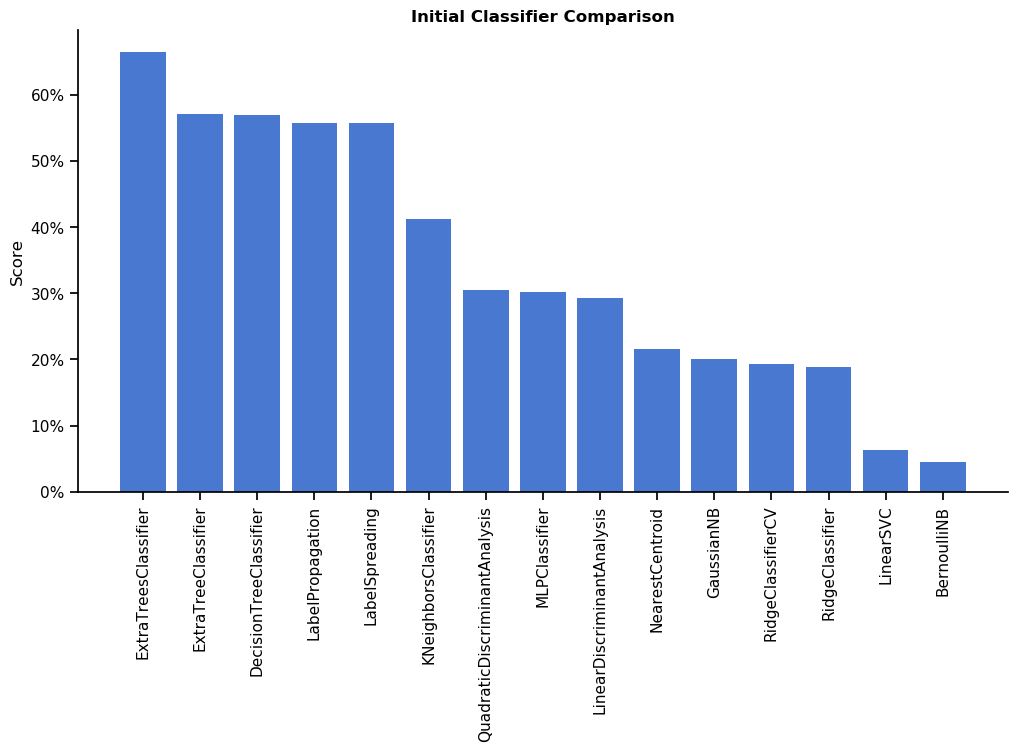

In [8]:
fig, ax = subplots(figsize=(12, 6))
ax.bar(classifiers[!, :name], classifiers[!, :score], color="C0")
ax.set_ylabel("Score")
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(xmax=1.0))
ax.set_title("Initial Classifier Comparison", weight="bold")

xticks(rotation=90)
sns.despine()

Based on this plot, the `ExtraTreesClassifier` seems to be the best choice for this data set, and it will be used in the remaining portions of the analysis.

## Tune hyperparameters and fit model
Due to the number of hyperparameters in the tuning set, `RandomizedSearchCV` is used to find and cross-validate the best hyperparameters (out of 100 random combinations) for the `ExtraTreesClassifier`. If the data set had less features or a smaller parameter space, `GridSearhCV` would be used instead to ensure that every combination of hyperparameters was tested.

According to the [documentation](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters), the most important parameters for `ExtraTreesClassifier` are `n_estimators` and `max_features`, with suggested values of `None` and `"sqrt"`, respectively. It is also suggested that `max_depth=None` and `min_samples_split=2` often correlate with good results, so all of these values are included in the search.

In [9]:
using ScikitLearn.GridSearch: RandomizedSearchCV
using ScikitLearn: fit!
n_estimators = 10 .^ range(0, stop=3)
max_features = ["auto", "log2", nothing]
min_samples_split = [2, 20, 200]
max_depth = [nothing, 1, 10, 100]
class_weight = [nothing, "balanced", "balanced_subsample"]
ccp_alpha = [0.0, 0.1, 0.5]
criterion = ["gini", "entropy"]

reg = ExtraTreesClassifier(n_jobs=-1)
gsc = RandomizedSearchCV(
    estimator=reg,
    param_distributions=Dict(
        :n_estimators => n_estimators,
        :max_features => max_features,
        :min_samples_split => min_samples_split,
        :max_depth => max_depth,
        :class_weight => class_weight,
        :ccp_alpha => ccp_alpha,
        :criterion => criterion
    ),
    cv=5,
    n_iter=100
)

fit!(gsc, X_train, y_train)
cls = ExtraTreesClassifier(
    max_features=gsc.best_params_[:max_features],
    min_samples_split=gsc.best_params_[:min_samples_split],
    n_estimators=gsc.best_params_[:n_estimators],
    max_depth=gsc.best_params_[:max_depth],
    class_weight=gsc.best_params_[:class_weight],
    ccp_alpha=gsc.best_params_[:ccp_alpha],
    criterion=gsc.best_params_[:criterion],
    n_jobs=-1
)
cls.fit(X_train, y_train)
@printf("Trained! Estimated accuracy %.2f%%", gsc.best_score_ * 100)

Trained! Estimated accuracy 89.65%

## Results

Because of the discrete nature of the classification, both `hist2d` and `scatter` look terrible here. Violin plots are used instead because they show the KDE of predicted qualities at each correct value of wine quality.

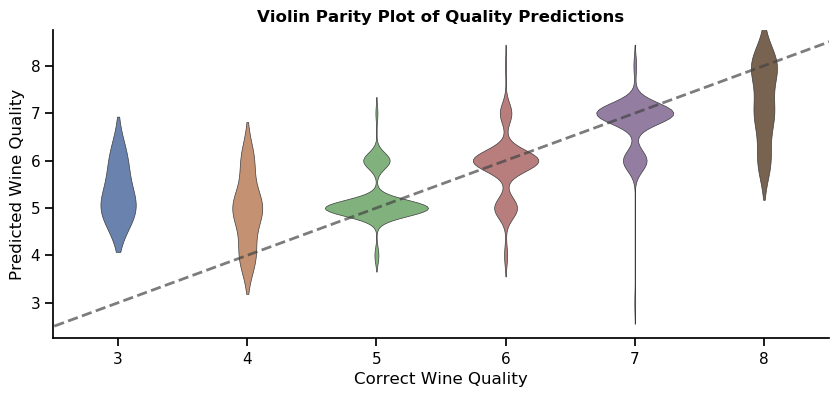

In [10]:
fig, ax = subplots(figsize=(10, 4))
sns.violinplot(
    y_test,
    cls.predict(X_test),
    ax=ax,
    inner=nothing,
    linewidth=0.5,
    saturation=0.5,
    scale="area",
)
ax.plot([-1, 6], [2, 9], color="#444444", alpha=0.7, ls="--", lw=2)
ax.set_xlim([-0.5, 5.5])
ax.set_ylim([2.25, 8.75])
ax.set_xlabel("Correct Wine Quality")
ax.set_ylabel("Predicted Wine Quality")
ax.set_title("Violin Parity Plot of Quality Predictions", weight="bold")
sns.despine()

From this plot it is evident that the classification model does a decent job of predicting mid- to high-quality wine, while over-predictsing low-quality wine. This isn't surprising given the distribution of quality data in the training set, which show the majority of classified wines to be on the interval $(5, 7)$. With no other modifications to the modeling pipeline, the use of SMOTE to correct the imbalance in wine classes improved the model's prediction from ~68% to ~90%, and brought the distributions of low- and high-quality wines closer to the parity line. This puts the color-agnostic ExtraTrees classifier in this notebook on par with the color-resolved SVM classifiers in the [original paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub), which reported accuracies of 89.0% and 86.8% for red and white wines, respectively.